# Hypsometric analysis for recent landslides

In [ ]:
import pip
pip.main(['install','matplotlib-scalebar'])

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import pysal

import warnings
warnings.filterwarnings("ignore")

Se importa poligono de la cuenca

,fid,Area_Km2,Perime_Km,_mean,_min,_max,_range,_mean_1,_min_1,_max_1,codigo,Indices_ma,Indices__1,geometry
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,0,"POLYGON ((456805.063 868201.875, 456805.063 86..."


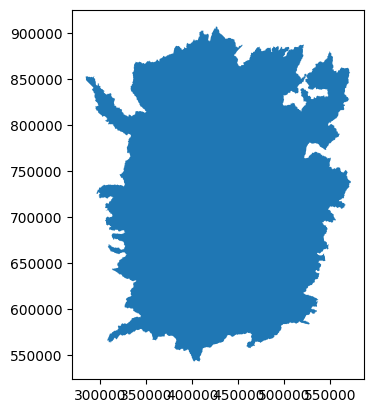

In [2]:
aoi=gpd.read_file("G:/My Drive/INVESTIGACION/POSDOC/Data/Vector/Area_estudio_poligono.shp")
aoi.plot()
aoi.head()

### Catchments with chi zonal statistic

In [3]:
chi_cat=gpd.read_file("G:/My Drive/INVESTIGACION/POSDOC/Data/Vector/subbasins_chi_zonalStatistic.gpkg")
chi_cat.head(2)

,OBJECTID,Id,gridcode,Área,Nombre,ID_CUENCA,hypso_inte,area_curva,Knickpoint,_chicount,_chimean,_chimedian,_chistdev,_chimin,_chimax,geometry
0,1,0.0,2827.0,120.181924,Quebrada Los San Andreses,0,0.107,0.096501,A,1362.0,10.017347,10.0760,2.848651,4.6349,16.0110,"MULTIPOLYGON (((411860.438 900002.542, 411964...."
1,2,1.0,3161.0,33.492364,Quebrada Sabalito,1,0.334,0.321164,A,365.0,6.036456,5.8155,1.697432,3.2042,9.9998,"MULTIPOLYGON (((505464.576 881616.272, 505673...."


### Catchments with Ks zonal statistical

In [4]:
k_cat=gpd.read_file("G:/My Drive/INVESTIGACION/POSDOC/Data/Vector/subbasins_Ks_zonalStatistic.gpkg")
k_cat.head(2)

,OBJECTID,Id,gridcode,Área,Nombre,ID_CUENCA,hypso_inte,area_curva,Knickpoint,_Kscount,_Ksmean,_Ksmedian,_Ksstdev,_Ksmin,_Ksmax,_Ksrange,geometry
0,1,0.0,2827.0,120.181924,Quebrada Los San Andreses,0,0.107,0.096501,A,1863.0,6.202666,3.7448,10.010615,0.040741,69.027,68.986259,"MULTIPOLYGON (((411860.438 900002.542, 411964...."
1,2,1.0,3161.0,33.492364,Quebrada Sabalito,1,0.334,0.321164,A,536.0,2.188858,1.9327,1.201385,1.108800,7.034,5.925200,"MULTIPOLYGON (((505464.576 881616.272, 505673...."


### Catchments with rainfall & estructural

Se importa archivo que se elaboro en QGIS de las cuencas con el valor de lluvia media anual proveniente de CHIRPS, el cual se elaboro inicialmente en Google Earth Engine y luego en QGIS se estimo el valor media para cada cuenca, y con el valor de la densidad estructural.

In [5]:
catchments=gpd.read_file("G:/My Drive/INVESTIGACION/POSDOC/Data/Vector/hypso3.gpkg")
catchments.head(2)

,OBJECTID,Id,gridcode,Área,hypso_inte,area_curva,Shape_Leng,Shape_Le_1,Shape_Area,Nombre,Lineamient,Densidad,_mean,knickpoint,geometry
0,1,4.0,2827.0,120.181924,0.107,0.096448,59628.024115,59459.370531,1.201791e+08,Quebrada Los San Andreses,294.0,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964...."
1,2,36.0,3161.0,33.492364,0.334,0.321148,41322.987731,41322.987731,3.349236e+07,Quebrada Sabalito,0.0,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673...."


Se eliminan columnas que no se van a utilizar

In [6]:
catchments.drop(["Id",'gridcode','area_curva','Shape_Leng','Shape_Le_1','Shape_Area','Lineamient'],axis=1,inplace=True)

Se proyecta a coordenadas planas, se modifica el nombre de la columna de lluvia.

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964...."
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673...."


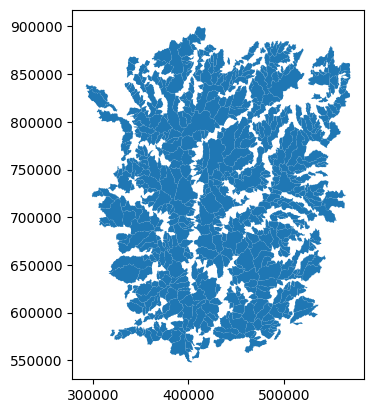

In [7]:
cat=catchments.to_crs(epsg=32618)
cat.rename(columns={"_mean":"rainfall_cat"}, inplace=True)
cat.plot()
cat.head(2)

## Recent landslides

In [8]:
recent=gpd.read_file("G:/My Drive/INVESTIGACION/POSDOC/Data/Vector/recent2_rainfall.gpkg")
recent.head(2)

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,date,source,elevation1,rainfall1,geometry
0,NaN,NaN,NaT,NaT,NaT,NaN,-1,0,-1,NaN,NaN,09/2006,My Places — _Points_,2363.0,2068.415506,POINT Z (439722.005 681812.005 0.000)
1,NaN,NaN,NaT,NaT,NaT,NaN,-1,0,-1,NaN,NaN,09/2011,My Places — _Points_,2881.0,2319.148033,POINT Z (437541.797 675246.253 0.000)


Se eliminan las columnas que nos e van a utilizar

In [9]:
rece=recent.drop(["Name","description","timestamp","begin","end","altitudeMode","tessellate","extrude","visibility","drawOrder","icon"],axis=1)

 Se cambia el nombre de la columna que tiene la lluvia, y se proyecta a coordenadas planas.

,date,source,elevation1,rainfall1,geometry
0,09/2006,My Places — _Points_,2363.0,2068.415506,POINT Z (439722.005 681812.005 0.000)
1,09/2011,My Places — _Points_,2881.0,2319.148033,POINT Z (437541.797 675246.253 0.000)


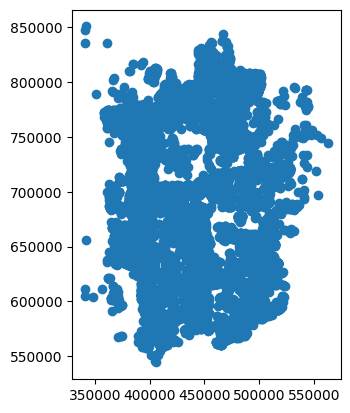

In [10]:
rece=rece.to_crs(epsg=32618)
rece.rename(columns={"SAMPLE_1":"rainfall_rec"}, inplace=True)
rece.plot()
rece.head(2)

Se realiza una interseccion espacial entre las cuencas 'cat' y los movimientos en masa recientes 'rec'. se agrupa por el numero de la cuenca para saber cuantos movimientos en masa hay por cuenca con la columna 'OBJECTID' que es unica (no tiene valores repetidos, cada cuenca tiene un valor unico) y se crea una dataframe.

NOTA= La columna "Nombre" no es unica, hay algunas pocas cuencas con el mismo nombre.

In [11]:
rec_join = gpd.sjoin(rece, cat, how="inner")
rec_by_cat=rec_join.groupby("OBJECTID").size()
rec_cat=pd.DataFrame({"rec_count": rec_by_cat})
rec_cat.head(2)

,rec_count
OBJECTID,
53,1
69,2


Se realiza un joint (no espacial) entre las cuencas 'cat' y el dataframe con el numero de movimientos en masa por cuenca 'land_cat' utilizando la columna 'OBJECTID' que es unica, y se crea una nueva columna con la densidad de movimientos en masa. Donde no hay movimientos en masa aparece un NaN.

In [12]:
rec = cat.join(rec_cat,on="OBJECTID") 
rec["rec_density"] = rec["rec_count"]/rec["Área"]
rec.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rec_count,rec_density
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",NaN,NaN
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",NaN,NaN


Se crean nuevas columnas para el numero de movimientos en masa y para hipsometria para solo las cuencas con movimientso en masa y para solo las ceuncas sin movimientos en masa, para poder graficar mejor.

In [13]:
rec["rec_count"]=rec["rec_count"].fillna(0) #column with all catchments (with and without landslides)
rec["rec_count_landcat"]=rec["rec_count"].replace(0,np.nan) #column with only catchments with landslides
rec["rec_count_Nolandcat"]=np.where(rec["rec_count"]>0,np.nan,rec["rec_count"]) #column with only catchments without landslides
rec["hypso_landcat"]=np.where(rec["rec_count"]==0,np.nan,rec["hypso_inte"])
rec["hypso_Nolandcat"]=np.where(rec["rec_count"]>0,np.nan,rec["hypso_inte"])
rec['hypso_with']=rec['hypso_landcat'].fillna(0)
rec['hypso_without']=rec['hypso_Nolandcat'].fillna(0)
rec['landslides']=np.where(rec["rec_count"]>0,'Recent lands.','No lands.')
rec.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rec_count,rec_density,rec_count_landcat,rec_count_Nolandcat,hypso_landcat,hypso_Nolandcat,hypso_with,hypso_without,landslides
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",0.0,NaN,NaN,0.0,NaN,0.107,0.0,0.107,No lands.
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",0.0,NaN,NaN,0.0,NaN,0.334,0.0,0.334,No lands.


## Relict landslides

In [14]:
relict=gpd.read_file("G:/My Drive/INVESTIGACION/POSDOC/Data/Vector/relict_rainfall.gpkg")
relict.head(2)

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,SAMPLE_1,geometry
0,El Guasimo,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,1841.776395,POINT Z (-75.86709 6.80850 753.10776)
1,El Noral,NaN,NaN,NaN,NaN,NaN,-1,0,-1,NaN,NaN,1946.703969,POINT Z (-75.50832 6.36266 1592.60560)


<Axes: >

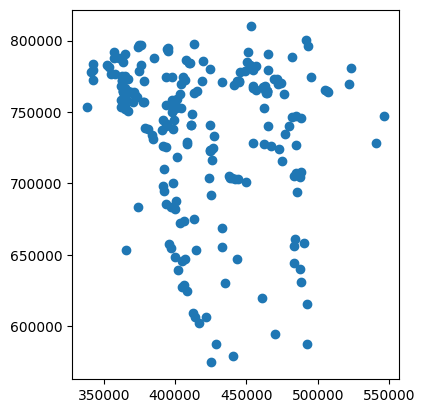

In [15]:
reli=relict.drop(["Name","descriptio","timestamp","begin","end","altitudeMo","tessellate","extrude","visibility","drawOrder","icon"],axis=1)
reli.rename(columns={"SAMPLE_1":"rainfall_rel"}, inplace=True)
reli=reli.to_crs(epsg=32618)
reli.plot()

In [16]:
rele_cat = gpd.sjoin(reli, cat, how="inner")
rel_by_cat=rele_cat.groupby("OBJECTID").size()
rel_cat=pd.DataFrame({"rel_count": rel_by_cat})
rel_cat.head(2)

,rel_count
OBJECTID,
97,2
107,1


In [17]:
rel = cat.join(rel_cat,on="OBJECTID")
rel["rel_density"] = rel["rel_count"]/rel["Área"]
rel.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rel_count,rel_density
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",NaN,NaN
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",NaN,NaN


In [18]:
rel["rel_count"]=rel["rel_count"].fillna(0) #column with all catchments (with and without landslides)
rel["rel_count_landcat"]=rel["rel_count"].replace(0,np.nan) #column with only catchments with landslides
rel["rel_count_Nolandcat"]=np.where(rel["rel_count"]>0,np.nan,rel["rel_count"]) #column with only catchments without landslides
rel["hypso_landcat"]=np.where(rel["rel_count"]==0,np.nan,rel["hypso_inte"])
rel["hypso_Nolandcat"]=np.where(rel["rel_count"]>0,np.nan,rel["hypso_inte"])
rel['hypso_with']=rel['hypso_landcat'].fillna(0)
rel['hypso_without']=rel['hypso_Nolandcat'].fillna(0)
rel['landslides']=np.where(rel["rel_count"]>0,'Ancient lands.','No lands.')
rel.head(2)

,OBJECTID,Área,hypso_inte,Nombre,Densidad,rainfall_cat,knickpoint,geometry,rel_count,rel_density,rel_count_landcat,rel_count_Nolandcat,hypso_landcat,hypso_Nolandcat,hypso_with,hypso_without,landslides
0,1,120.181924,0.107,Quebrada Los San Andreses,2.446291,2250.332866,E,"MULTIPOLYGON (((411860.438 900002.542, 411964....",0.0,NaN,NaN,0.0,NaN,0.107,0.0,0.107,No lands.
1,2,33.492364,0.334,Quebrada Sabalito,0.000000,3457.470653,A,"MULTIPOLYGON (((505464.576 881616.272, 505673....",0.0,NaN,NaN,0.0,NaN,0.334,0.0,0.334,No lands.


#### Import dataframe catchments

In [19]:
cat_9 = pd.read_csv(r"G:/My Drive/INVESTIGACION/POSDOC/GLM/df2.csv")
cat_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Nombre              643 non-null    object 
 1   ID_CUENCA           643 non-null    float64
 2   cuenca              643 non-null    object 
 3   area                643 non-null    int64  
 4   geometry            643 non-null    object 
 5   hypso_inte          643 non-null    float64
 6   _Ksmean             643 non-null    float64
 7   _chimean            643 non-null    float64
 8   rainfall_cat        643 non-null    float64
 9   Densidad            643 non-null    float64
 10  elev_mean           643 non-null    float64
 11  slope_mean          643 non-null    float64
 12  rel_mean            643 non-null    float64
 13  kmeans              643 non-null    object 
 14  RainfallDaysmean    643 non-null    float64
 15  RainfallDaysmedian  643 non-null    float64
 16  Rainfall

In [20]:
cat_rel=cat_9[cat_9["lands_rel"]>0]
cat_rec=cat_9[cat_9["lands_rec"]>0]
cat_land=cat_9[cat_9["landslides"]>0]
cat_nland=cat_9[cat_9["landslides"]==0]

## Figura

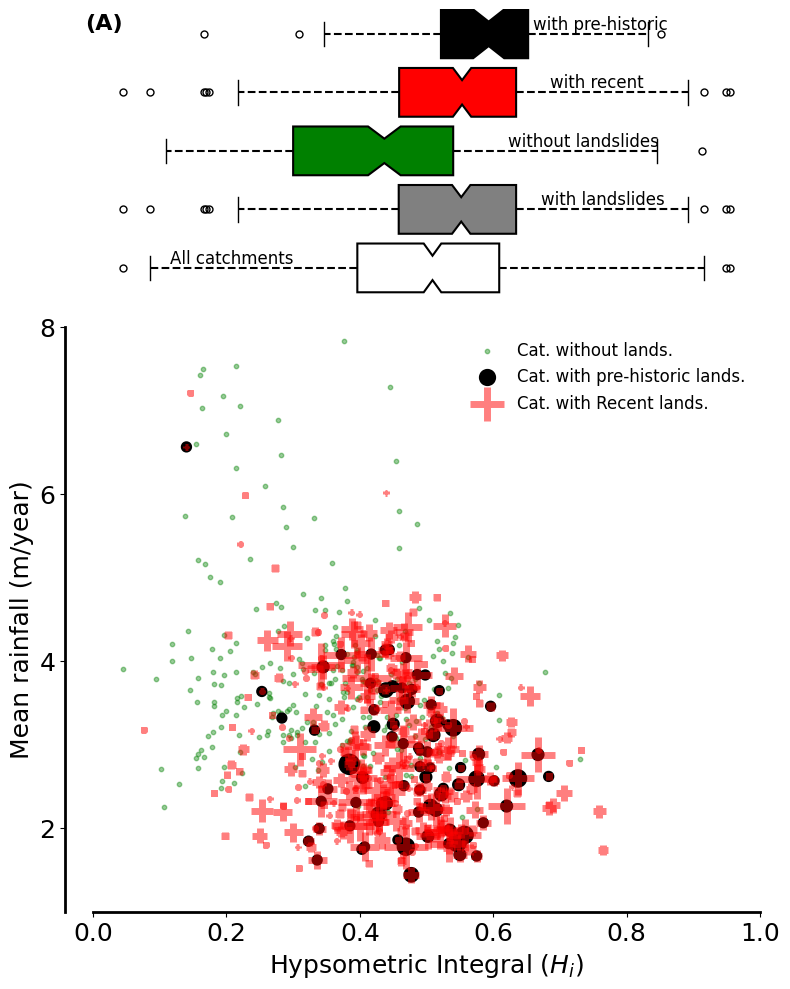

In [33]:
f,ax=plt.subplots(2,1,figsize=(8,10),gridspec_kw={'height_ratios': [1, 2]})

bplot=ax[0].boxplot([cat_9["hypso_inte"],cat_land["hypso_inte"],cat_nland["hypso_inte"],cat_rec["hypso_inte"],cat_rel["hypso_inte"]],
           vert=False,
           patch_artist = True,
           widths = 1,
           boxprops=dict(linewidth=1.5),
           showmeans=False,
           meanline=False,
           notch=True,
           whiskerprops = dict(linestyle = "dashed",linewidth=1.5),
           flierprops = dict(marker = "o", markersize = 5, markeredgecolor = "black"),
           medianprops= dict(linestyle = "solid", linewidth = 0),
           positions=[0.7,1.9,3.1,4.3,5.5],
           labels=['All Catchments','Catchments \nwith landslides','Catchments \nwithout landslides','Catchments with\nRecent landslides','Catchments with\npre-historic landslides'])
# fill with colors
color=['white','gray','green','red','black']
for patch, color in zip(bplot['boxes'], color):
    patch.set_facecolor(color)
ax[0].set_ylim(0,6)
sbn.despine(ax=ax[0],offset={'left': 20})
ax[0].set(yticklabels=[],xticklabels=[])  # remove the tick labels
ax[0].tick_params(left=False,bottom=False)  # remove the ticks
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].text(0.1, 0.8, 'All catchments', color='black', weight='roman',size=12)
ax[0].text(0.54, 2, 'with landslides', color='black', weight='roman',size=12)
ax[0].text(0.50, 3.2, 'without landslides', color='black', weight='roman',size=12)
ax[0].text(0.55, 4.4, 'with recent', color='black', weight='roman',size=12)
ax[0].text(0.53, 5.6, 'with pre-historic', color='black', weight='roman',size=12)
ax[0].text(0.0, 5.6,"(A)",size=16,weight='bold')

ax[1].scatter(rec["hypso_Nolandcat"],rec["rainfall_cat"]/1000,s=40, facecolors='green', marker=".",edgecolors='green',color="green",alpha=0.4,label="Cat. without lands.")
ax[1].scatter(rel["hypso_landcat"],rel["rainfall_cat"]/1000,edgecolor='black',marker=".",linewidths=5,s=rel["rel_count"]*40,color='black',label="Cat. with pre-historic lands.") #s=rec["rec_count"]*10,
ax[1].scatter(rec["hypso_landcat"],rec["rainfall_cat"]/1000,edgecolor='red',marker='+',linewidths=5,s=rec["rec_count"]*4,color='red',alpha=0.5,label="Cat. with Recent lands.") #s=rel["rel_count"]*10,
ax[1].set_xlabel('Hypsometric Integral ($H_i$)',size=18)
ax[1].set_ylabel('Mean rainfall (m/year)',size=18)
ax[1].set_yticks(np.arange(0,8.1,2))
ax[1].set_xticks(np.arange(0,1.001,0.2))
ax[1].tick_params(axis='y', labelsize=18)
ax[1].tick_params(axis='x', labelsize=18)
ax[1].set_xlim(0,1)
ax[1].set_ylim(1,8)
for axis in ['bottom','left']:
    ax[1].spines[axis].set_linewidth(2)
sbn.despine(ax=ax[1],offset={'left': 20})

#ax2=ax[1].twinx()
#log=cat_9[["hypso_inte","prob"]].sort_values(by='prob', ascending=False)
#model1 = np.poly1d(np.polyfit(log["hypso_inte"], log["prob"], 5))
#ax2.plot(log["hypso_inte"], model1(log["hypso_inte"]), color='green',linewidth=3,alpha=0.8)
#ax2.scatter(cat_9["hypso_inte"],cat_9["prob"],edgecolor='green',color='none',alpha=0.8)
#sbn.despine(ax=ax2,offset={"right":20},top=True,left=True,bottom=True, right=False)
#ax2.spines['right'].set_linewidth(2)
#ax2.set_yticks(np.arange(0,0.8,0.2))
#ax2.tick_params(axis='y', color='green',labelsize=18)
#ax2.set_ylabel('P(y=landslides/x=$H_i$)',size=18,color='green')
#ax2.spines['right'].set_color('green')
#ax2.tick_params(colors='green', which='both')

plt.legend(loc="upper right",frameon=False,prop={'size': 12})
f.tight_layout() 
plt.savefig("G:/My Drive/INVESTIGACION/POSDOC/Figuras/hypso_rainfall2.png", dpi=500)